In [2]:
import os,csv,re
import random, torch
import cv2
import SpaGCN as spg
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy as sch
import scipy.sparse as sp
import squidpy as sq

In [42]:
adata = ad.read_h5ad("adata.h5ad")

In [43]:
adata

AnnData object with n_obs × n_vars = 28317 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts'
    var: 'n_cells'
    obsm: 'spatial'

# testing spatial domain prediction on one tissue separately

In [55]:
# choosing 2 tissues to test the model on merfush data
adata1=adata[adata.obs['Bregma']==-0.04]
adata2=adata[adata.obs['Bregma']==-0.09]

In [56]:
(adata.obs['Bregma']).unique()()

array([-0.04, -0.09, -0.14, -0.19, -0.24])

In [57]:
adata1.obs["x_pixel"]=adata1.obs["Centroid_X"]
adata1.obs["y_pixel"]=adata1.obs["Centroid_Y"]
adata1.obs["x_array"]=adata1.obs["Centroid_X"]
adata1.obs["y_array"]=adata1.obs["Centroid_Y"]

#Set coordinates
x_pixel1=adata1.obs["x_pixel"].tolist()
y_pixel1=adata1.obs["y_pixel"].tolist()
x_array1=adata1.obs["x_array"].tolist()
y_array1=adata1.obs["y_array"].tolist()




adata2.obs["x_pixel"]=adata2.obs["Centroid_X"]
adata2.obs["y_pixel"]=adata2.obs["Centroid_Y"]
adata2.obs["x_array"]=adata2.obs["Centroid_X"]
adata2.obs["y_array"]=adata2.obs["Centroid_Y"]

#Set coordinates
x_pixel2=adata2.obs["x_pixel"].tolist()
y_pixel2=adata2.obs["y_pixel"].tolist()
x_array2=adata2.obs["x_array"].tolist()
y_array2=adata2.obs["y_array"].tolist()

/tmp/ipykernel_33/2675249217.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1.obs["x_pixel"]=adata1.obs["Centroid_X"]
/tmp/ipykernel_33/2675249217.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs["x_pixel"]=adata2.obs["Centroid_X"]


In [58]:
# calculate adj matrix of the coordination
adj1=spg.calculate_adj_matrix(x=x_pixel1,y=y_pixel1, histology=False)
spg.prefilter_genes(adata1,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata1)


adj2=spg.calculate_adj_matrix(x=x_pixel2,y=y_pixel2, histology=False)
spg.prefilter_genes(adata2,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata2)


Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...


In [59]:
#Section 1
adata1.var_names_make_unique()
adata1.raw=adata1
sc.pp.normalize_per_cell(adata1, min_counts=0)
sc.pp.log1p(adata1)

#Section 2
adata2.var_names_make_unique()
adata2.raw=adata2
sc.pp.normalize_per_cell(adata2, min_counts=0)
sc.pp.log1p(adata2)

#Set parameters
p=0.05 
l1=spg.search_l(p, adj1, start=0.01, end=1000, tol=0.01, max_run=100)
l2=spg.search_l(p, adj2, start=0.01, end=1000, tol=0.01, max_run=100)

l_list=[l1, l2]
res=0.2
adata_list=[adata1, adata2]
adj_list=[adj1, adj2]
#Set seed
r_seed=t_seed=n_seed=1000

#Multi-section SpaGCN
clf=spg.multiSpaGCN()
clf.train(adata_list,adj_list,l_list,n_clusters=17,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
# n_clusters was 8
#Get results
y_pred, prob=clf.predict()
adata_all=clf.adata_all
adata_all.obs["pred"]= y_pred
adata_all.obs["pred"]=adata_all.obs["pred"].astype('category')
ref_id=adata_all.obs["dataset_batch"]=="0"
a0=adata_all[ref_id,:].copy()
a1=adata_all[~ref_id,:].copy()
#a0 contains results for section 1, a1 for section 2.


Run 1: l [0.01, 1000], p [0.0, 3620.61977019255]
Run 2: l [0.01, 500.005], p [0.0, 1739.4111328125]
Run 3: l [0.01, 250.0075], p [0.0, 571.4368896484375]
Run 4: l [0.01, 125.00874999999999], p [0.0, 159.5873260498047]
Run 5: l [0.01, 62.509375], p [0.0, 41.85332107543945]
Run 6: l [0.01, 31.2596875], p [0.0, 10.534401893615723]
Run 7: l [0.01, 15.63484375], p [0.0, 2.424396514892578]
Run 8: l [0.01, 7.822421875], p [0.0, 0.44257867336273193]
recommended l =  3.9162109375
Run 1: l [0.01, 1000], p [0.0, 3694.5959048584823]
Run 2: l [0.01, 500.005], p [0.0, 1787.820556640625]
Run 3: l [0.01, 250.0075], p [0.0, 591.7874755859375]
Run 4: l [0.01, 125.00874999999999], p [0.0, 166.67356872558594]
Run 5: l [0.01, 62.509375], p [0.0, 43.93852233886719]
Run 6: l [0.01, 31.2596875], p [0.0, 11.105072021484375]
Run 7: l [0.01, 15.63484375], p [0.0, 2.563276767730713]
Run 8: l [0.01, 7.822421875], p [0.0, 0.4639921188354492]
recommended l =  3.9162109375


/opt/conda/lib/python3.10/site-packages/SpaGCN/SpaGCN.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  self.adata_all=AnnData.concatenate(*adata_list,join='inner',batch_key="dataset_batch",batch_categories=batch_cat)


Initializing cluster centers with louvain, resolution =  0.2
Epoch  0
Epoch  10
Epoch  20
delta_label  0.004617473970122227 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 25


In [60]:
a0

AnnData object with n_obs × n_vars = 5488 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts', 'x_pixel', 'y_pixel', 'x_array', 'y_array', 'dataset_batch', 'pred'
    var: 'n_cells'
    obsm: 'spatial'

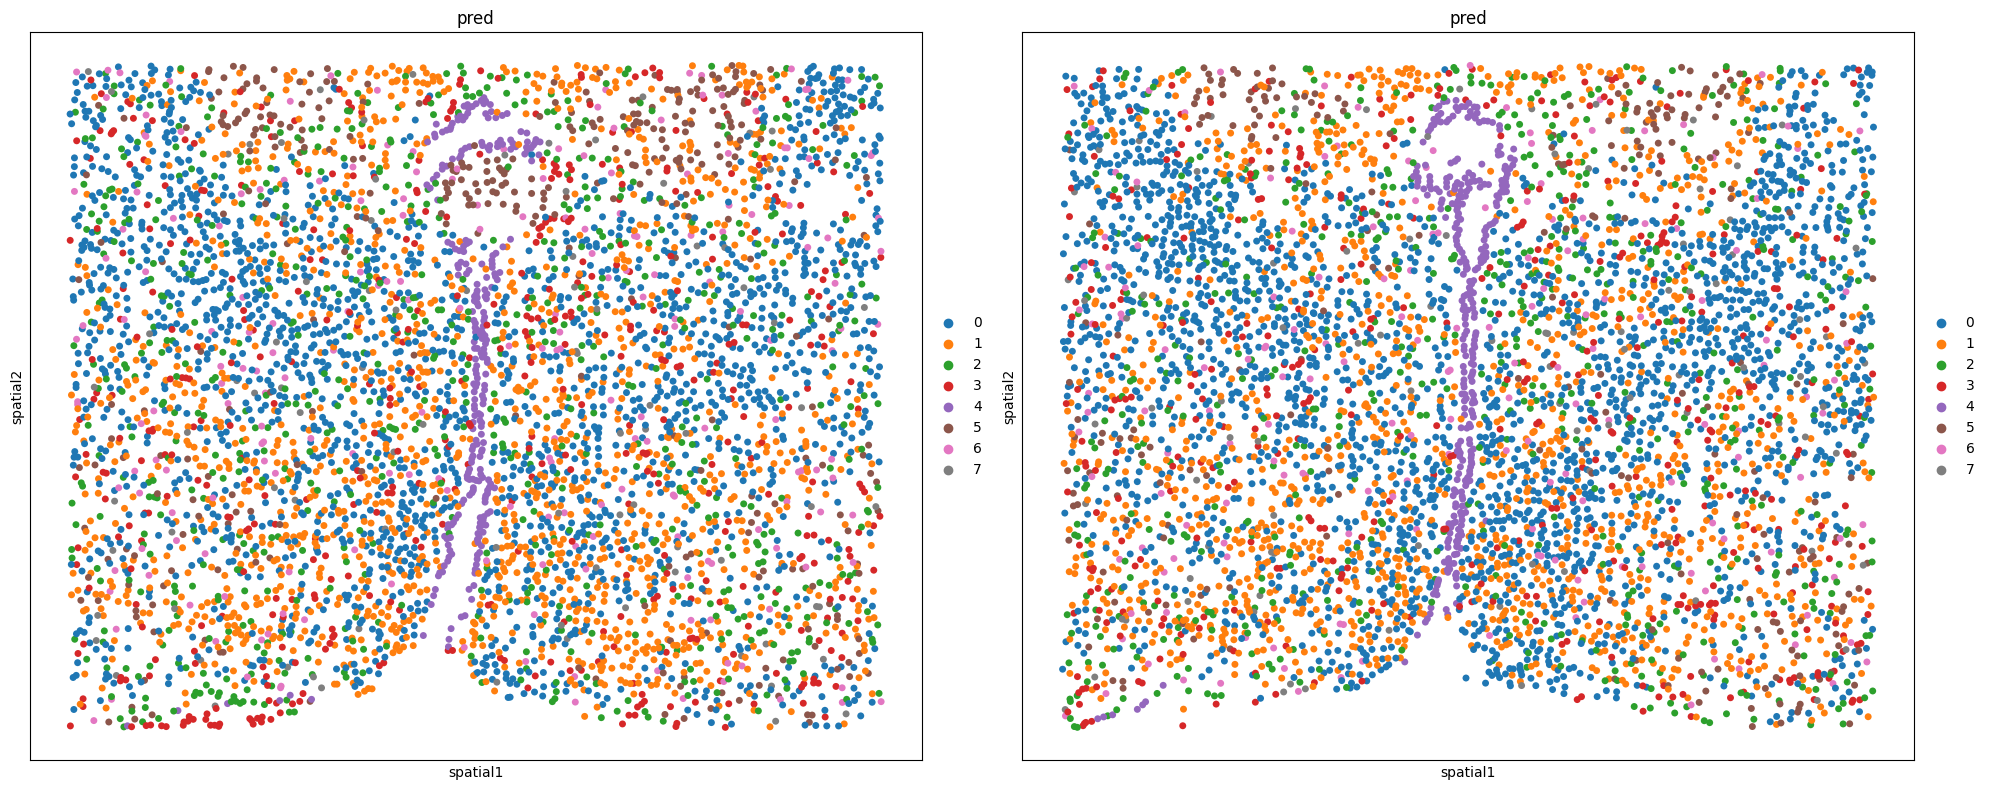

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sc.pl.embedding(a0, basis="spatial", color="pred",ax=axs[0],size=100,show=False)
sc.pl.embedding(a1, basis="spatial", color="pred",ax=axs[1],size=100,show=False)
# Adjust layout
plt.tight_layout()
plt.show()

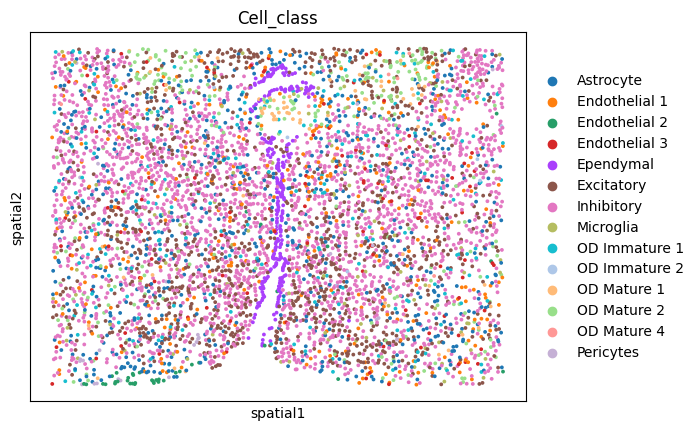

In [21]:
sc.pl.embedding(a0, basis="spatial", color="Cell_class",size=30)


# testing domain prediction on all tissue combined 

In [64]:
adata.uns['spatial']= adata.obsm['spatial']

In [65]:
adata.obs["x_pixel"]=adata.obs["Centroid_X"]
adata.obs["y_pixel"]=adata.obs["Centroid_Y"]
adata.obs["x_array"]=adata.obs["Centroid_X"]
adata.obs["y_array"]=adata.obs["Centroid_Y"]

#Set coordinates
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()

In [90]:
#Calculate adjacent matrix for coordinations
s=1
b=49
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)


Calculateing adj matrix using xy only...


In [91]:
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [92]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 3853.0550017776095]
Run 2: l [0.01, 500.005], p [0.0, 1773.1005859375]
Run 3: l [0.01, 250.0075], p [0.0, 582.642822265625]
Run 4: l [0.01, 125.00874999999999], p [0.0, 163.8465576171875]
Run 5: l [0.01, 62.509375], p [0.0, 43.213626861572266]
Run 6: l [0.01, 31.2596875], p [0.0, 10.903772354125977]
Run 7: l [0.01, 15.63484375], p [0.0, 2.5046305656433105]
Run 8: l [7.822421875, 15.63484375], p [0.4524325132369995, 2.5046305656433105]
Run 9: l [7.822421875, 11.728632812499999], p [0.4524325132369995, 1.279005527496338]
Run 10: l [7.822421875, 9.77552734375], p [0.4524325132369995, 0.813095211982727]
Run 11: l [7.822421875, 8.798974609375], p [0.4524325132369995, 0.6193493604660034]
Run 12: l [7.822421875, 8.310698242187499], p [0.4524325132369995, 0.5325237512588501]
recommended l =  8.06656005859375


In [94]:
n_clusters=8 # the number of known domains in the preoptic region
#Set seed
r_seed=t_seed=n_seed=100
#Search for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  12
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  11
Res changed to 0.6
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Res =  0.5 Num of clusters =  10
Res changed to 0.5
Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Res =  0.4 Num of clusters =  9
Res changed to 0.4
Initializing cluster centers with louvain, resolution =  0.30000000000000004
Epoch  0
Epoch  10
Res =  0.30000000000000004 Num of clusters =  8
recommended res =  0.30000000000000004


In [95]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="square")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
adata.write_h5ad("results.h5ad")

Initializing cluster centers with louvain, resolution =  0.30000000000000004
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
delta_label  0.004873397605678568 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 40
Calculateing adj matrix using xy only...


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


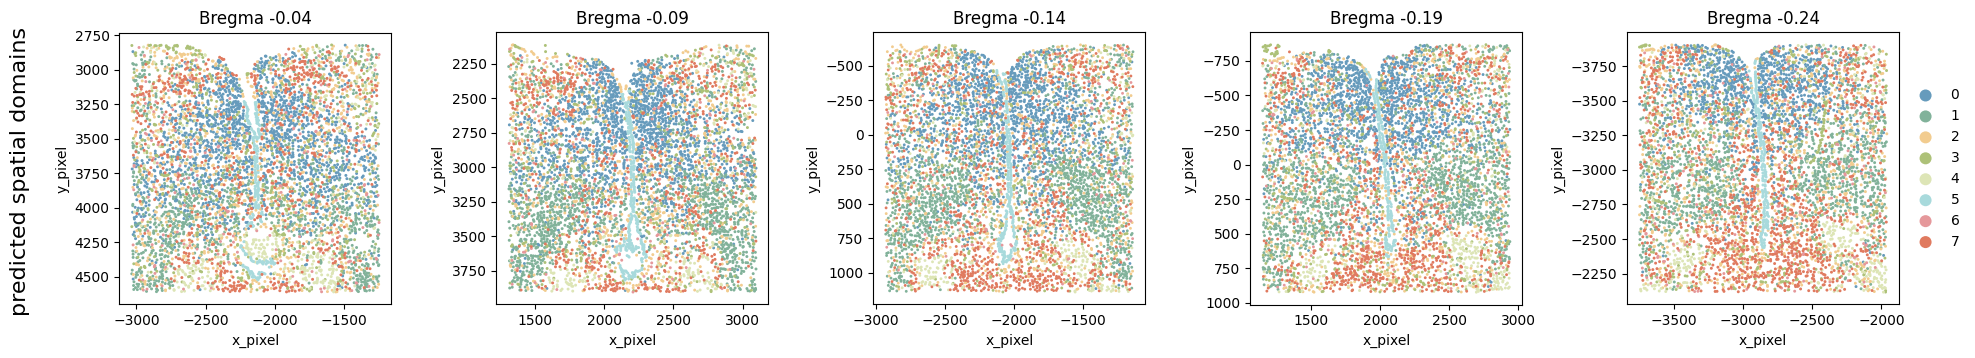

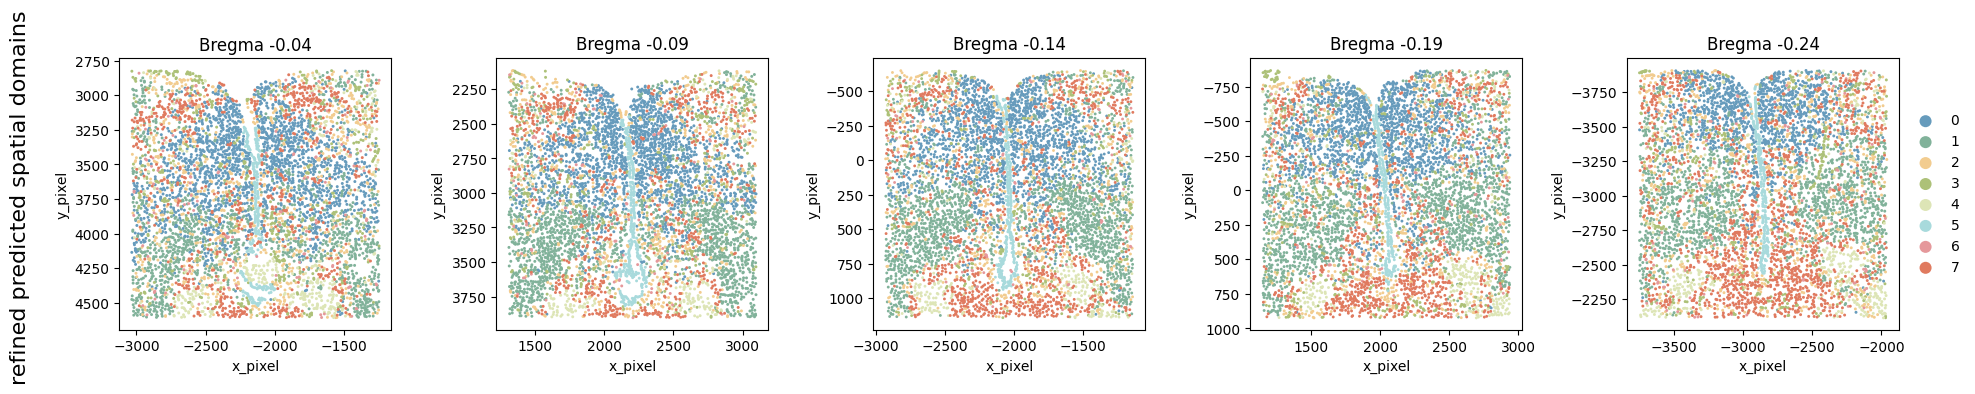

In [96]:
# pltoing the predicted domain across all Bregma tissues

# Set the colors
plot_color = ["#669bbc", "#81b29a", "#f2cc8f", "#adc178", "#dde5b6", "#a8dadc", "#e5989b", "#e07a5f"]

# Define the Bregma sections
bregma_sections = [-0.04, -0.09, -0.14, -0.19, -0.24]

# Create a figure with 1 row and len(bregma_sections) columns
fig, axs = plt.subplots(1, len(bregma_sections), figsize=(20, 4))

# Plot the spatial domains for each Bregma section
domains = "pred"

for idx, bregma in enumerate(bregma_sections):
    # Subset the AnnData object for the current Bregma section and make a copy
    adata_slice = adata[adata.obs["Bregma"] == bregma].copy()

    # Set the colors based on the number of unique cell types
    unique_celltypes = adata_slice.obs[domains].unique()
    num_celltype = len(unique_celltypes)

    # Ensure that there are enough colors for the unique cell types
    if num_celltype > len(plot_color):
        # If not enough colors, generate additional colors dynamically
        cmap = plt.get_cmap('tab20')
        extra_colors = [cmap(i) for i in np.linspace(0, 1, num_celltype)]
        adata_slice.uns[domains + "_colors"] = extra_colors
    else:
        adata_slice.uns[domains + "_colors"] = plot_color[:num_celltype]

    # Plot the scatter plot for the current Bregma section
    ax = sc.pl.scatter(
        adata_slice,
        alpha=1,
        x="x_pixel",
        y="y_pixel",
        color=domains,
        title=f"Bregma {bregma}",
        ax=axs[idx],
        show=False,
        size=100000 / adata_slice.shape[0],
        legend_loc='none'
    )

    # Set equal aspect ratio and invert the y-axis
    ax.set_aspect('equal', 'box')
    ax.axes.invert_yaxis()
ax = sc.pl.scatter(adata[adata.obs["Bregma"] == -0,24],alpha=1,x="x_pixel",y="y_pixel",color=domains,title=f"Bregma -0.24",ax=axs[4],show=False,size=100000 / adata_slice.shape[0])
# Adjust layout
plt.tight_layout(rect=[0.03, 0.03, 1, 0.93])  
fig.text(0.02, 0.50, 'predicted spatial domains', va='center', ha='center', rotation='vertical', fontsize=16)
plt.show()

# Plot refined spatial domains for each Bregma section
fig, axs = plt.subplots(1, len(bregma_sections), figsize=(20, 4))
domains = "refined_pred"

for idx, bregma in enumerate(bregma_sections):
    # Subset the AnnData object for the current Bregma section and make a copy
    adata_slice = adata[adata.obs["Bregma"] == bregma].copy()

    # Set the colors based on the number of unique cell types
    unique_celltypes = adata_slice.obs[domains].unique()
    num_celltype = len(unique_celltypes)

    # Ensure that there are enough colors for the unique cell types
    if num_celltype > len(plot_color):
        # If not enough colors, generate additional colors dynamically
        cmap = plt.get_cmap('tab20')
        extra_colors = [cmap(i) for i in np.linspace(0, 1, num_celltype)]
        adata_slice.uns[domains + "_colors"] = extra_colors
    else:
        adata_slice.uns[domains + "_colors"] = plot_color[:num_celltype]

    # Plot the scatter plot for the current Bregma section
    ax = sc.pl.scatter(
        adata_slice,
        alpha=1,
        x="x_pixel",
        y="y_pixel",
        color=domains,
        title=f"Bregma {bregma}",
        ax=axs[idx],
        show=False,
        size=100000 / adata_slice.shape[0],
        legend_loc='none')

    # Set equal aspect ratio and invert the y-axis
    ax.set_aspect('equal', 'box')
    ax.axes.invert_yaxis()
ax = sc.pl.scatter(adata[adata.obs["Bregma"] == -0,24],alpha=1,x="x_pixel",y="y_pixel",color=domains,title=f"Bregma {bregma}",ax=axs[4],show=False,size=100000 / adata_slice.shape[0])
# Adjust layout
plt.tight_layout(rect=[0.03, 0.03, 1, 0.93])  
fig.text(0.02, 0.5, 'refined predicted spatial domains', va='center', ha='center', rotation='vertical', fontsize=16)
plt.show()

In [ ]:
adata.write('adata.h5ad')